## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [13]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
#unzip
!unzip "/content/gdrive/My Drive/Assignment/CNN_assignment" > /dev/null

In [15]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [16]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [18]:


#Train
image_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_train)

#Test
image_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


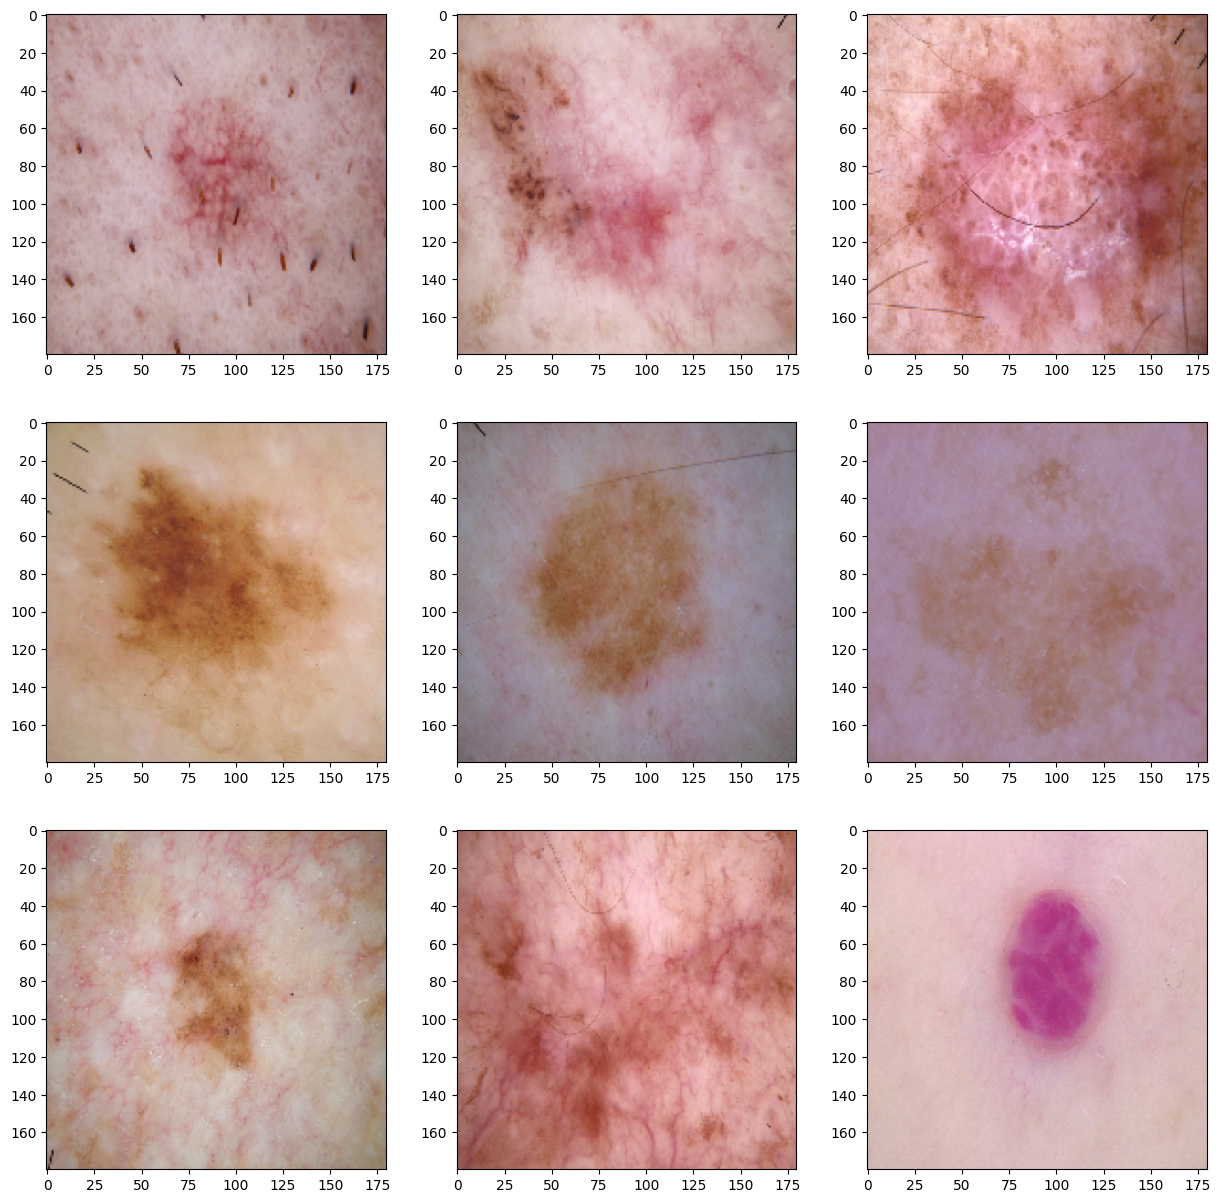

In [19]:

image_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)


class_names = image_data.class_names

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))

**Visualize distribution of classes in the training dataset.**

In [20]:
def distribution_count(directory):

    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))


    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]


    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

dataframe = distribution_count(data_dir_train)
dataframe

,Class,No. of Image
0,vascular lesion,139
1,basal cell carcinoma,376
2,squamous cell carcinoma,181
3,melanoma,438
4,dermatofibroma,95
5,pigmented benign keratosis,462
6,actinic keratosis,114
7,nevus,357
8,seborrheic keratosis,77


<Axes: xlabel='No. of Image', ylabel='Class'>

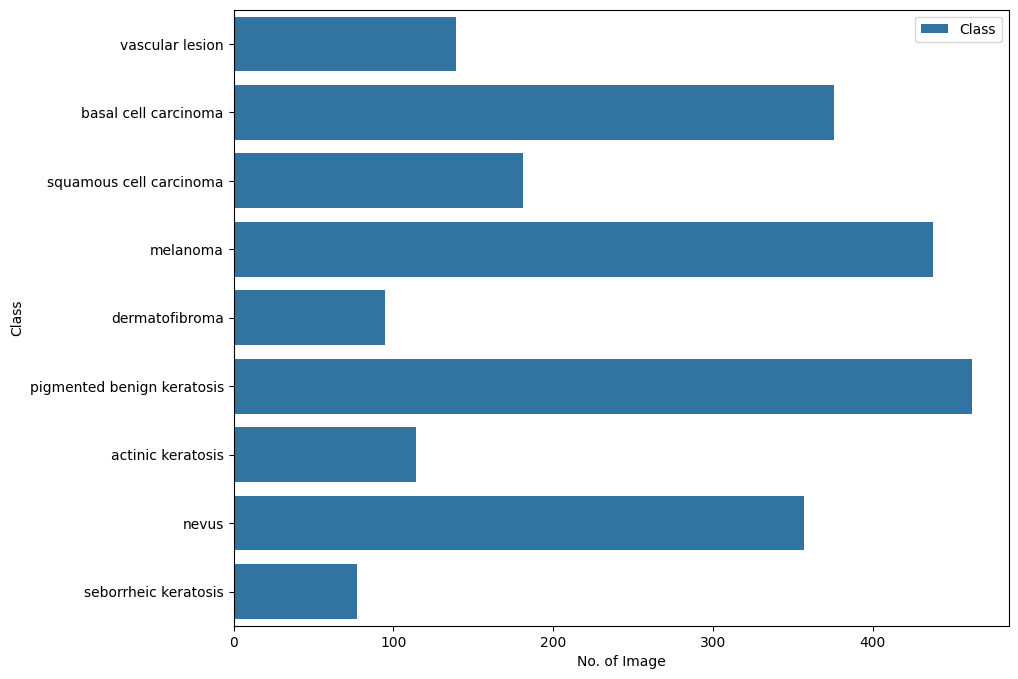

In [22]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=dataframe,
            label="Class")

In [23]:
#Augmentor installation
!pip install Augmentor

In [24]:
training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E893464C310>: 100%|██████████| 500/500 [00:14<00:00, 33.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E893D444910>: 100%|██████████| 500/500 [00:15<00:00, 33.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E89341BABF0>: 100%|██████████| 500/500 [00:15<00:00, 32.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7E8934075AE0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2155x1958 at 0x7E8934693C10>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8934499720>: 100%|██████████| 500/500 [00:14<00:00, 33.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8934077C70>: 100%|██████████| 500/500 [00:34<00:00, 14.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E8934690070>: 100%|██████████| 500/500 [00:14<00:00, 34.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8937CEF3A0>: 100%|██████████| 500/500 [00:14<00:00, 33.43 Samples/s]


In [25]:
#Count total number of images generated using Augmentor.
image_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_train)

4500


**Model Building**

In [26]:
# train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [27]:
# validation dataset
validation_dataset =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [30]:
#autotuning

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:

mod = Sequential()
#Rescaling
mod.add(layers.Rescaling(1./255, input_shape=(180,180,3)))   # Changed to layers.Rescaling

#FirstConvulation
mod.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
mod.add(layers.MaxPool2D(pool_size=(2,2)))

#SecondConvulation
mod.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
mod.add(layers.MaxPool2D(pool_size=(2,2)))

#ThirdConvulation
mod.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
mod.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout
mod.add(layers.Dropout(0.5))

#Flatten Layer
mod.add(layers.Flatten())

#Dense Layer
mod.add(layers.Dense(128,activation='relu'))

mod.add(layers.Dropout(0.25))

mod.add(layers.Dense(len(class_names),activation='softmax'))

mod.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

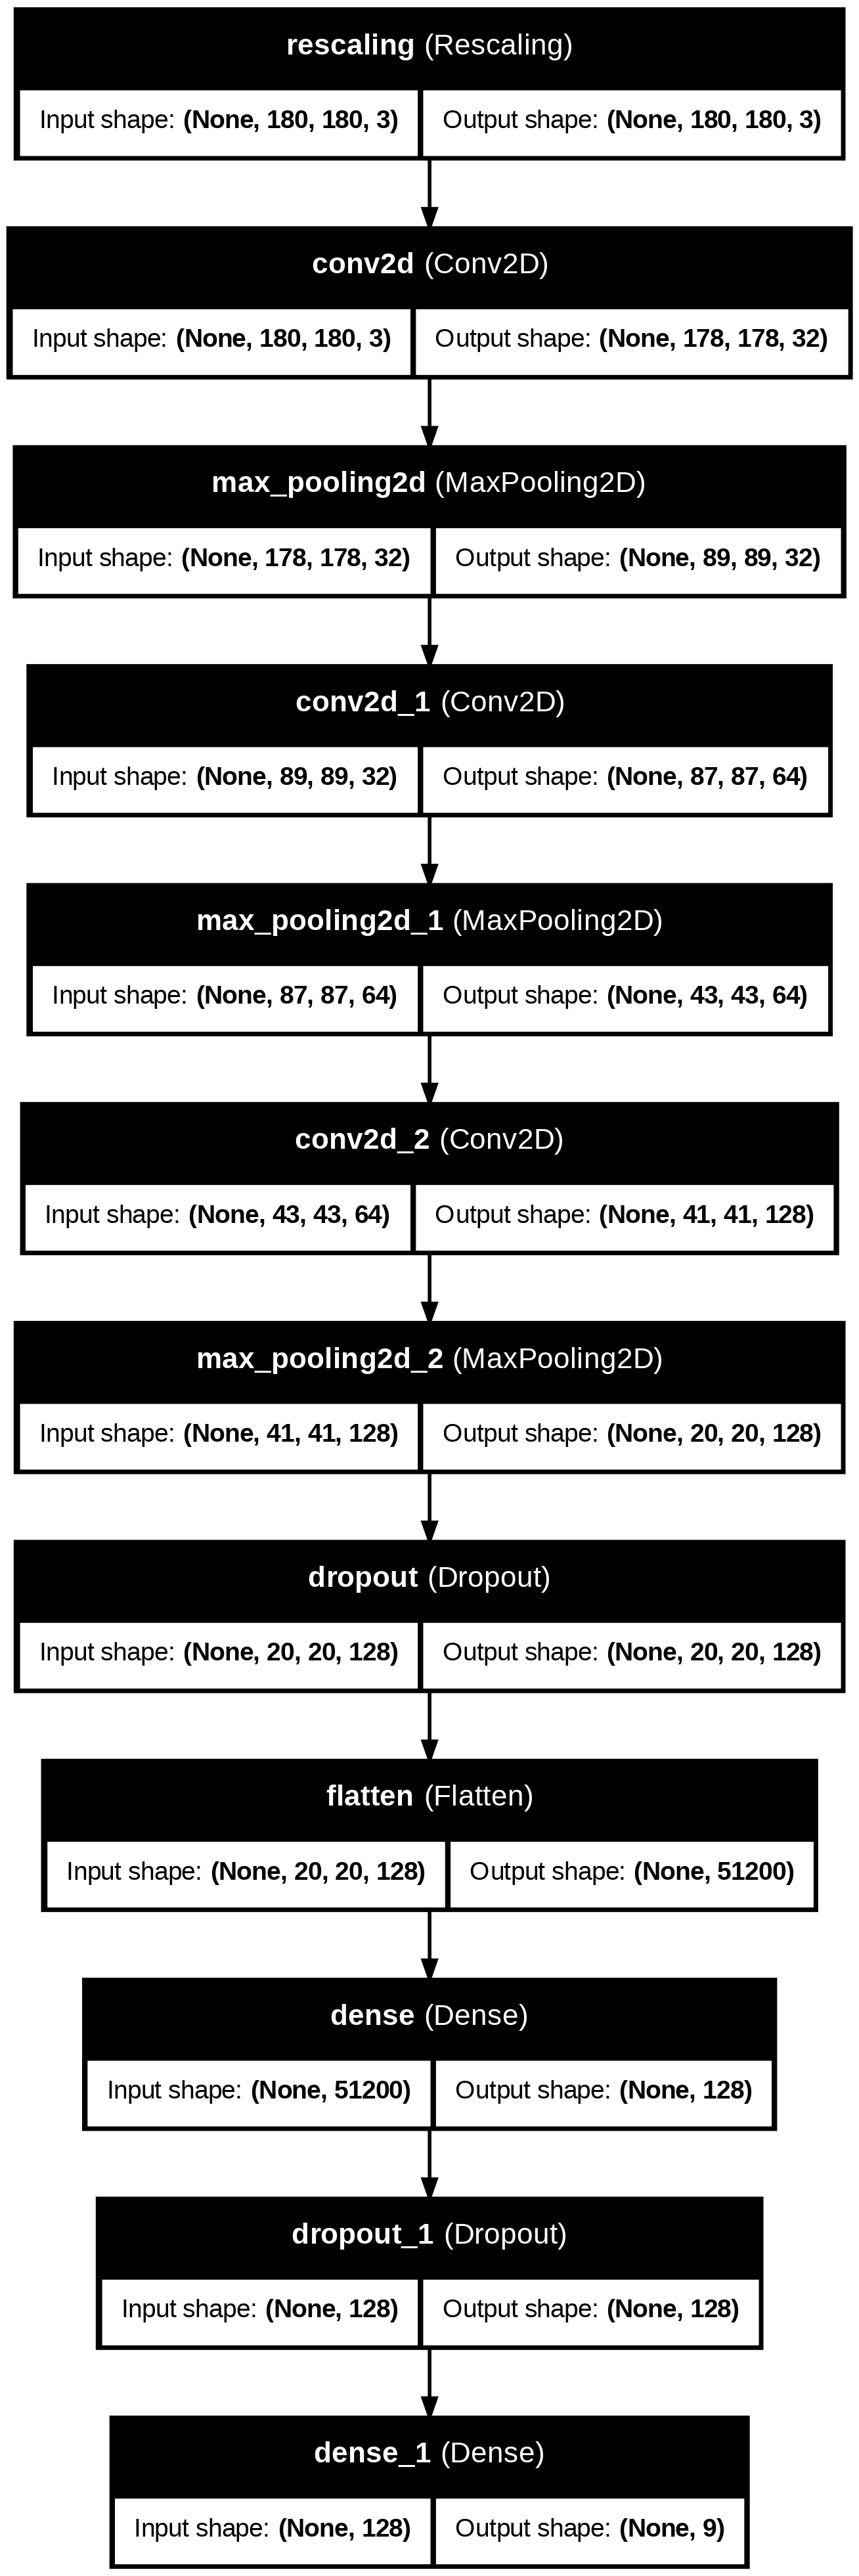

In [33]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(mod, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
#model compilation



mod.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


checkpoint = ModelCheckpoint("model.keras",monitor="validation_accuracy",save_best_only=True,mode="auto",verbose=1)

stop = EarlyStopping(monitor="validation_accuracy",patience=5,mode="max",verbose=1)

In [43]:
# Train the model
epochs = 20
history = mod.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoint,stop])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4873 - loss: 1.3864 - val_accuracy: 0.5212 - val_loss: 1.2326
Epoch 2/20
  5/169 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6057 - loss: 1.0376

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `validation_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5739 - loss: 1.1462 - val_accuracy: 0.5412 - val_loss: 1.2429
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6210 - loss: 1.0469 - val_accuracy: 0.5880 - val_loss: 1.0948
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6335 - loss: 1.0085 - val_accuracy: 0.6630 - val_loss: 0.9364
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6894 - loss: 0.8096 - val_accuracy: 0.7120 - val_loss: 0.8396
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7383 - loss: 0.6904 - val_accuracy: 0.7216 - val_loss: 0.7860
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7676 - loss: 0.6281 - val_accuracy: 0.7498 - val_loss: 0.7057
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7929 - loss: 0.5626 - val_accuracy: 0.6058 - val_loss: 1.2137
Epoch 9/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7644 - loss: 0.6425 - val_accuracy: 0.

KeyError: 'validation_accuracy'

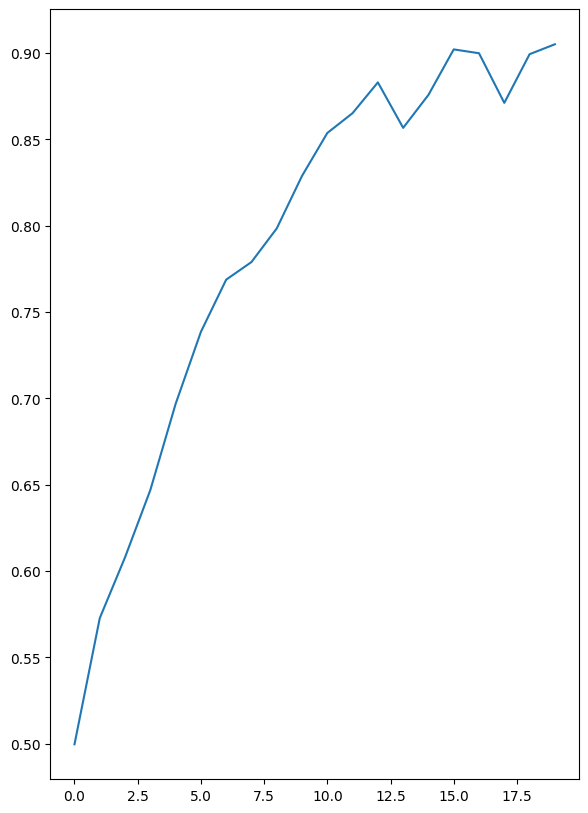

In [44]:
# Plot the training curves
# epochs = 20
# history = mod.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoint,stop])

epoch_Ranges= range(stop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs)
plt.legend(['training', 'validation'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['validation_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs)
plt.legend(['training', 'validation'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


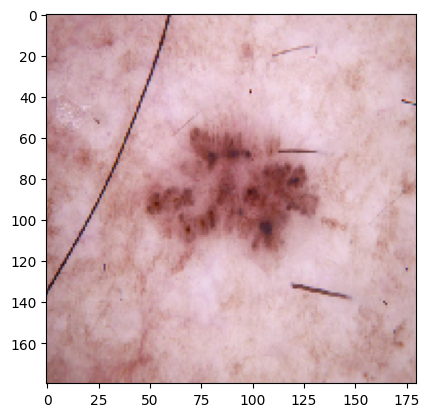

In [45]:
from glob import glob
Test_image_location = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_location)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = mod.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )